# MidiNetモデルの学習

- DataLoaderの作成
- Modelの作成
- 学習コードの作成
- 学習経過の可視化

In [1]:
import os, glob, ipdb, platform, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer
from IPython.display import clear_output, Audio
from scipy.io import wavfile as spw
from pydub import AudioSegment as AS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0,128], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("chord shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

In [5]:
def to_device(data):
    if not isinstance(data, torch.Tensor):
        data = torch.from_numpy(data)
    if torch.cuda.is_available():
        return data.cuda()
    return data.cpu()

## Modelの作成

#### model用共通関数の作成

In [6]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=True):
    if x.ndim == 2:
        return nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    elif x.ndim == 3:
        return nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    else:
        return x

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

#### Generator
forwardの入力
- z (batch, noise_size) = (72, 113): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 16, 128): 前の小節
- y (batch, 13): コード，0~11次元はコードの主音，12次元目はmajorかminorかを区別する

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 16, 128): 生成された今の小節
    
オリジナルのmidinetと同じ．詳しい説明はmidinet_understandingを参照

In [7]:
class Generator(nn.Module):
    def __init__(self, pitch_range=128):
        super(Generator, self).__init__()
        self.gf_dim  = 64
        self.y_dim   = 13

        self.h1      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h3      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=157, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))

        self.linear1 = nn.Linear(113,1024)
        self.linear2 = nn.Linear(1037,self.gf_dim*2*2*1)

    def forward(self, z, prev_x, y, batch_size):
        
        h0_prev = lrelu(batch_norm(self.h0_prev(prev_x)))   # 72, 16, 16, 1
        h1_prev = lrelu(batch_norm(self.h1_prev(h0_prev)))  # 72, 16, 8, 1
        h2_prev = lrelu(batch_norm(self.h2_prev(h1_prev)))  # 72, 16, 4, 1
        h3_prev = lrelu(batch_norm(self.h3_prev(h2_prev)))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 13, 1, 1

        z = torch.cat((z,y),1)                              # 72, 113

        h0 = F.relu(batch_norm(self.linear1(z)))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1037

        h1 = F.relu(batch_norm(self.linear2(h0)))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim * 2, 2, 1)     # 72, 128, 2, 1
        h1 = concat_vector(h1, yb)                          # 72, 141, 2, 1
        h1 = concat_vector(h1, h3_prev)                     # 72, 157, 2, 1

        h2 = F.relu(batch_norm(self.h1(h1)))                # 72, 128, 4, 1
        h2 = concat_vector(h2, yb)                          # 72, 141, 4, 1
        h2 = concat_vector(h2, h2_prev)                     # 72, 157, 4, 1

        h3 = F.relu(batch_norm(self.h2(h2)))                # 72, 128, 8, 1 
        h3 = concat_vector(h3, yb)                          # 72, 141, 8, 1
        h3 = concat_vector(h3, h1_prev)                     # 72, 157, 8, 1

        h4 = F.relu(batch_norm(self.h3(h3)))                # 72, 128, 16, 1
        h4 = concat_vector(h4, yb)                          # 72, 141, 16, 1
        h4 = concat_vector(h4, h0_prev)                     # 72, 157, 16, 1

        g_x = torch.sigmoid(self.h4(h4))                    # 72, 1, 16, 128

        return g_x

#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 16, 128): real/fake判定を行う小節データ
- y (batch, 13) = (72, 13): コード

forwardの出力
- h3_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h3 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果
- fm (batch, 1+13, steps, pitch) = (72, 14, 8, 1): 特徴マップ．

オリジナルのmidinetと同じ．詳しい説明はmidinet_understandingを参照

In [8]:
class Discriminator(nn.Module):
    def __init__(self, pitch_range=128):
        super(Discriminator, self).__init__()

        self.df_dim = 64
        self.dfc_dim = 1024
        self.y_dim = 13
        
        # out channels = y_dim +1 
        self.h0_prev = nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(2,pitch_range), stride=(2,2))

        # out channels = df_dim + y_dim
        self.h1_prev = nn.Conv2d(in_channels=27, out_channels=77, kernel_size=(4,1), stride=(2,2))
        self.linear1 = nn.Linear(244, self.dfc_dim)
        self.linear2 = nn.Linear(1037, 1)

    def forward(self, x, y, batch_size):        

        yb = y.view(batch_size,self.y_dim, 1, 1)
        x = concat_vector(x, yb)                    #72, 14, 16, 128
        
        h0 = lrelu(self.h0_prev(x))                 #72, 14, 8, 1
        fm = h0
        h0 = concat_vector(h0, yb)                  #72, 27, 8, 1

        h1 = lrelu(batch_norm(self.h1_prev(h0)))    #72, 77, 3, 1
        h1 = h1.view(batch_size, -1)                #72, 231
        h1 = torch.cat((h1,y), 1)                   #72, 244

        h2 = lrelu(batch_norm(self.linear1(h1)))
        h2 = torch.cat((h2,y), 1)                   #72, 1037

        h3 = self.linear2(h2)
        h3_sigmoid = torch.sigmoid(h3)


        return h3_sigmoid, h3, fm

## 学習コードの作成

In [9]:
version = 'natural'
input_data_path = os.path.join(base_dir, "midinet_natural.pkl")

In [10]:
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

save_npa = lambda file_name, npa: np.save(os.path.join(save_dir, file_name), npa)

### ハイパーパラメータの設定

In [11]:
epochs = 500
batch_size = 9192
generator_train_times = 10
sample_bar_num = 16 # 学習過程で保存する画像の小節数

# for Adam
lr = 0.0002
betas = (0.5, 0.999)

# noise vector size
nz = 100

# a coefficient to real label for discriminator. 0 ~ 1
real_data_worthiness = 0.9

# feature matching coefficients
lambda_1, lambda_2 = 10, 10 # D, G

### 学習初期化処理  

In [12]:
data_loader = get_dataloader(input_data_path, batch_size=batch_size)
data_size = len(data_loader.dataset) // batch_size

Data loading is completed.
20 batches from 181725 bars are obtained.


In [13]:
netD = Discriminator()
netG = Generator()

if torch.cuda.is_available():
    netD = netD.cuda()
    netG = netG.cuda()

netD.train()
netG.train()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=betas)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=betas)

noise_for_sample = to_device(torch.randn(sample_bar_num, nz))

realD_list, fakeD_list = [], [] # Dのrealデータとfakeデータに対するエポックごとの識別結果平均(realに対しては1に近く，fakeに対しては0に近い方がDが強い)
lossD_list, lossG_list = [], [] # D, Gのロスのエポックごとの誤差
saved_image_paths = []

### 学習ループ
オリジナルのコードを若干書き換え  
ノイズベクトルは毎回作り直すことにしてみる

In [14]:
print("start leaning...")
for epoch in range(1, epochs+1):
    sum_lossD, sum_lossG = 0, 0
    sum_realD, sum_fakeD = 0, 0
    
    with Timer():
        for i, (real, prev, chord) in enumerate(data_loader):

            # バッチ(譜面，前の譜面，コード)をdeviceに渡す  
            real, prev, chord = [to_device(item) for item in [real, prev, chord]]

            # batchの切れ端はサイズが異なる場合があるので注意
            batch_size = real.size(0)

            ############################
            # Dの学習: log(D(x)) + log(1 - D(G(z))) を最大化
            # realデータを1，fakeデータを0と判断させるよう学習
            ###########################

            # Dの勾配の初期化
            netD.zero_grad()

            # realに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_real, d_logits_real, fm_real = netD(real, chord, batch_size)
            d_real_label = real_data_worthiness * torch.ones_like(d_real)
            d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

            # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成
            noise = to_device(torch.randn(batch_size, nz))
            fake = netG(noise, prev, chord, batch_size)

            # fakeに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_fake, d_logits_fake, fm_fake = netD(fake.detach(), chord, batch_size)
            d_fake_label = torch.zeros_like(d_fake)
            d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

            # 誤差逆伝搬により勾配を更新し，それに基づきDのパラメータを更新する
            lossD = d_loss_real + d_loss_fake
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # 学習記録
            # real, fakeデータに対してそれぞれrealだと識別した割合
            realD, fakeD = d_real.mean().item(), d_fake.mean().item()
            sum_realD += realD
            sum_fakeD += fakeD
            sum_lossD += lossD.item() # Dの学習におけるLoss


            ############################
            # Gの学習 : log(D(G(z)))を最大化
            # fakeデータを1と判断させるよう学習
            ###########################

            for t in range(generator_train_times):

                # Gの勾配の初期化
                netG.zero_grad()

                # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成 (やっぱりいちいち作ったほうが結果がよさそう)
                noise = to_device(torch.randn(batch_size, nz))
                fake = netG(noise, prev, chord, batch_size)
                
                # fakeに対して1をラベルとした識別結果からクロスエントロピー誤差(目的関数)の値を得てGの誤差とする
                d_fake, d_logits_fake, fm_fake = netD(fake, chord, batch_size)
                deceive_label = torch.ones_like(d_fake)
                g_loss = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label) # (72, 1), (72, 1) => scalar tensor

                # Dの特徴マッチング：realとfakeでnetDの初段のreluの出力が近くなるようにする
                features_from_g = torch.mean(fm_fake, 0) # fakeデータに対するDのfeatureの平均値
                features_from_i = torch.mean(fm_real, 0) # realデータに対するDのfeatureの平均値
                # fakeとrealの出すfeatureの違いが大きいほどペナルティを与える
                fm_g_loss1 = nn.MSELoss(reduction='sum')(features_from_g, features_from_i) / 2
                fm_g_loss1 = torch.mul(fm_g_loss1, lambda_1)

                # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                mean_image_from_g = torch.mean(fake, 0) # fakeデータの平均値
                mean_image_from_i = torch.mean(real, 0) # realデータの平均値
                # fakeデータとrealデータの違いが大きいほどペナルティを与える
                fm_g_loss2 = nn.MSELoss(reduction='sum')(mean_image_from_g, mean_image_from_i) / 2
                fm_g_loss2 = torch.mul(fm_g_loss2, lambda_2)

                # 誤差逆伝搬により勾配を更新し，それに基づきGのパラメータを更新する
                lossG = g_loss + fm_g_loss1 + fm_g_loss2
                lossG.backward(retain_graph=(t < generator_train_times - 1)) # 最後は計算グラフを放棄
                optimizerG.step()

            # 学習記録
            sum_lossG += lossG.item() # Gの学習におけるLoss
    
        clear_output()
        print(f"epoch {epoch} / {epochs} result")

        # エポックごとの識別と誤差の記録
        realD_list.append(sum_realD / data_size)
        fakeD_list.append(sum_fakeD / data_size)
        lossD_list.append(sum_lossD / data_size)
        lossG_list.append(sum_lossG / data_size)
        print(f'==> avg lossD: {lossD_list[-1]:.4f} avg lossG: {lossG_list[-1]:.4f}, avg realD: {realD_list[-1]:.4f}, avg fakeD: {fakeD_list[-1]:.4f} ')
        print(f'==> loss D: {lossD:.4f} loss G: {lossG:.4f} = {g_loss:.4f} + {fm_g_loss1:.4f} + {fm_g_loss2:.4f} real D: {realD:.4f} fake D: {fakeD:.4f}')
        
    # 10エポックごとに生成データを画像で記録
    if epoch % 10 == 0:
        sample_fake = netG(noise_for_sample, prev[:sample_bar_num], chord[:sample_bar_num], sample_bar_num).detach()
        _, _, steps, pitch_range = sample_fake.shape
        sample_fake = sample_fake.reshape(sample_bar_num*steps, pitch_range).T

        fake_image_path = os.path.join(save_dir, f'fake_samples_epoch{epoch:03}.png')
        saved_image_paths.append(fake_image_path)
        vutils.save_image(sample_fake, fake_image_path, normalize=True)

print("finished!")

epoch 500 / 500 result
==> avg lossD: 1.4481 avg lossG: 0.8555, avg realD: 0.4742, avg fakeD: 0.4730 
==> loss D: 1.3777 loss G: 0.8190 = 0.8011 + 0.0049 + 0.0130 real D: 0.4505 fake D: 0.4492
38.690194
finished!


モデルと記録の保存

In [15]:
save_npa('realD_list.npy', realD_list)
save_npa('fakeD_list.npy', fakeD_list)
save_npa('lossD_list.npy', lossD_list)
save_npa('lossG_list.npy', lossG_list)
hyper_param_str = f"epoch={epoch}_nx={nz}_l1={lambda_1}_l2={lambda_2}_gt={generator_train_times}_rw={real_data_worthiness}"
torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_{hyper_param_str}.pth'))
torch.save(netD.state_dict(), os.path.join(save_dir, f'netD_{hyper_param_str}.pth'))

生成データの画像を表示

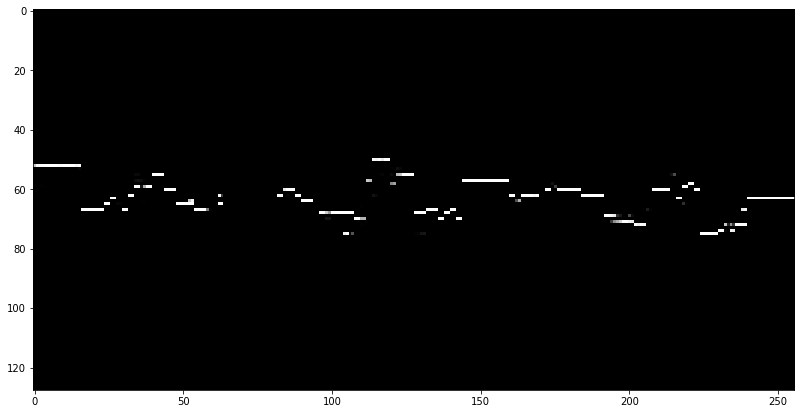

In [16]:
img = np.array(Image.open(saved_image_paths[-1]))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)

### 誤差グラフの表示

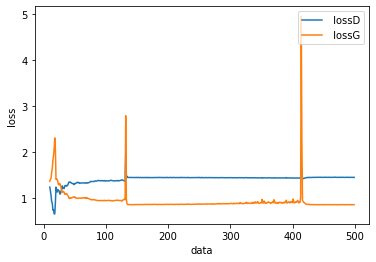

In [17]:
burn_in = 10

lossD_print = np.load(os.path.join(save_dir, 'lossD_list.npy'))[burn_in:]
lossG_print = np.load(os.path.join(save_dir, 'lossG_list.npy'))[burn_in:]

length = lossG_print.shape[0]
x = np.asarray(np.linspace(burn_in, burn_in + length-1, length))
plt.figure()
plt.plot(x, lossD_print,label=' lossD', linewidth=1.5)
plt.plot(x, lossG_print,label=' lossG', linewidth=1.5)
plt.legend(loc='upper right')
plt.xlabel('data')
plt.ylabel('loss')
plt.savefig(os.path.join(save_dir, f'loss_graph_lr={lr}_epoch={epochs}.png'))
plt.show()

# 考察

- generatorの訓練時には毎回ノイズを生成し直した方が良い．
    - そうしないとGがDに勝てなくなってデータを生成しなくなる
    - いい結果とは，
        - DとGのロスが拮抗する状態が続き，段々GがDより強くなっていく
        - ある程度細かい音符が使われ，多様性を感じさせる譜面を生成する(ずっとドだけ，とかがダメ)
- 結構エポックに時間はかからない．1エポック10~30sec.
- originalは毎回ノイズを生成し直す点以外は元のmidinetと同様の設定であった．
    - epochは1000にした．
    - GがDに割と負けていたがepoch後半になってくると急激にGが勝利できるようになる瞬間があった
    - スケールから外れる音が多いが，音の細かさの多様性はあってよかった
        - 外れる原因はaugumentationにある？
        - メジャースケールのみでaugumentationすればよい？
    - 生成データは，音程ごとに
        - 最大値の例：1.0978e-13
        - 平均値の例：8.5766e-16
        - と，非常に小さな値のレンジで生成を行っていた
- original2は$\lambda_1, \lambda_2 = 10, 1$, Dが1回に対してGを10回学習させた
    - 学習過程はよかったが，生成データは多くのステップで同じ音を鳴らすつまらないものになることがある
    - しかしひとたび細かい音符を生成するようになればいい感じの音になる
    - 2小節目でずっと同じ音になってしまうと，そこから先も同じようになってしまう
    - lossD = 0.9403 + 0.0754 + 0.0141みたいな感じなので，$\lambda_2$も10にした方がいい？
- naturalも$\lambda_1, \lambda_2 = 10, 1$, Dが1回に対してGを10回学習させた
    - 後半はlossDのfeature2の割合が増えてきたのでやっぱ係数このままでいいかな？
    - naturalをメジャースケールに水増しすればいいかんじにならないかな？
    - originalの時もだったんだけどGが突然Dより強くなる時がある
    - 生成された音楽は基本的にメジャースケールに則ったものになったので聞き心地はよくなった
    - しかし生成イメージがまばらなので若干暴れ気味
    - あとレンジ外の音を出さなくなったっぽい
    - 休符に対応できるようにもして，1e-2くらいをすべてが下回ったら休符にすると良い感じになった
    - しかしフレーズの繰り返し的なことをさせるにはやはり全体を見る必要があるか？
- naturalのエポックを1000, $\lambda_2$も10にしてみた
    - 前と同じようにGのロスが上がってったかと思いきや突然Dに勝ち始めるやつ
    - 250エポック辺りからほぼ変化なし
    - 基本的にスケールから外れることはなくなったことが分かる
    - スケールには則っているが，音飛びが発生することが結構ある
    - しかし，メロディは滑らかで多様性のあるものになっており，聞き心地は結構いい
    - もうほとんど同ステップ上で分布がばらけることはなくなった.一つ1.0で他がほぼ0みたいなところも結構ある
- natural2ではメジャースケール上での水増しを行い，200エポック学習
    - 学習過程や生成イメージは今までに似ている
    - しかし，naturalよりも音符が細かいことが多かった
    - しかも，スケールを外すので，そもそもこの水増し手法はあんまりよくなさそう
    - データも十分あるので，トランスポーズによる水増しをするよりは，今ある曲をなるべく削らないように作ったほうがよさそう
- 結果，今のところepoch=1000のnaturalが一番良い感じの曲を作ってくれそうと思いつつ音飛びの少ないnatural2の方が良いかも

- shift in rangeがミスってたので最初から
    - ごちゃってきたので使用データセットをまとめる
        - original: 論文のもの．例外的なのはガリガリ削り，12トランスポーズで水増し
        - natural: 小節消したり，音符を伸ばしたりしないで，オクターブも下に1オクターブ増やす
            - 大きな音符ばかりであまり気の効いた結果にはならなかった
            - せめてEmptyBarの排除くらいはやったほうがいい気がしてきた

- 多分GANは我々が思っているよりも高い表現力を持っているので次のような前処理でも行けそう
    - 提示されているkeyはあてにならないので，estimated_keyに合わせてトランスポーズする
    - downresolutionいらない説 -> 24 resolutionで作る
    - 1小節に複数のコードがあることを表現するコードベクトルにする -> 拍ごとにコードチェックし，13×4=52次元のベクトルにする
    - prevが変わってしまうのでコードは削らない
    - よく見たら展開形とか使われてたので，ちゃんとコードチェックする必要がある
    - トランスポーズによる水増しを行わない
    - section: verse,chorusなど，小節のセクション情報を6次元ベクトルにしてコードベクトルに結合したもの
    - clipped: MIDI音程を36～99の64ピッチ以内にシフトし，64入力のモデルで学習
    - midinetをベースにして入力に合わせてパラメータ数を調整したmidinet2にしてしまう

- そしてSelf-Attentionを導入したい

次はinception scoreとFIDを導入してみたい．  
なんだかDがちゃんと機能してくれてなさそうなので